In [ ]:
# MLP(Multi-Layer Perceptron) - Fashion MNIST Dataset

# 딥러닝 MLP 아키텍처
# - 학습데이터 -> 입력층>은닉층>ReLU>Dropout>출력층>Softmax -> 손실함수

# 입력층
# - (28,28) 크기를 가지는 2차원 이미지를 784개(28x28)의 길이를 갖는 1차원 벡터로 변환해서 은닉층으로 전달
# 은닉층
# - 일반적으로 1개 이상의 은닉층으로 이루어지며 각각의 은닉층은 내부에 많은 노드(node)로 구성
# - 은닉층 개수과 노드 개수는 학습데이터와 성능을 고려하여 최적의 값을 찾아야 하는 하이퍼 파라미터
# ReLU
# - 활성화함수로서 입력값이 0보다 크면 입력값 그대로 내보내고, 0보다 작으면 0을 출력하는 비선형함수
# Dropout
# - 학습데이터에 대해 과적합(overfitting)을 줄이기 위해 신경망 뉴런을 주어진 확률값에 따라 부분적으로 제거(drop)해주는 함수
# 출력층
# - 출력층 노드 개수는 정답(label) 개수와 같은 10개로 설정
# - 학습데이터의 정답은 0~9까지 총 10개 가운데 하나의 숫자로 표현되기 때문에 출력층 노드 개수가 또한 정답 개수와 동일한 10개
# Softmax
# - 다중 클래스 분류 모델을 만들때 사용
# - 입력된 벡터의 각 요소를 0~1 사이의 확률값으로 변환해주는 함수
# 학습
# - StepLR : 일정 에폭마다 학습률을 감소시킨다.
# - EarlyStopping : 일정 에폭 동안 성능 향상이 없을 경우 학습을 조기 중단, 과적합 방지, 학습 시간 절약
# 시각화
# - confusion_matrix(혼돈 행렬), classification_report

In [2]:
# 1) import, GPU 설정
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('pytorch version : ', torch.__version__, ', device : ', DEVICE)

pytorch version :  2.2.2 , device :  cpu


In [3]:
# 2) MNIST Dataset 다운로드
train_dataset = datasets.FashionMNIST(root='./data/FashionMNIST_data',
                               train=True, # train
                               transform=transforms.ToTensor(), # 이미지 픽셀값 0~255까지의 값을 0~1 사이의 값을 변환
                               download=True)

test_dataset = datasets.FashionMNIST(root='./data/FashionMNIST_data',
                               train=False, # test
                               transform=transforms.ToTensor(),
                               download=True)

In [4]:
# 데이터 확인
print(len(train_dataset), len(test_dataset))

60000 10000


In [5]:
# 3) MNIST Dataset 분리(train : validation = 85% : 15%)
train_dataset_size = int(len(train_dataset) * 0.85) # train 85%
# validation_dataset_size = int(len(train_dataset) * 0.15) # validation 15%
validation_dataset_size = len(train_dataset) - train_dataset_size # validation 15%
train_dataset, validation_dataset = random_split(dataset=train_dataset,
                                                 lengths=[train_dataset_size, validation_dataset_size])

In [6]:
# 분리된 데이터 확인
print(len(train_dataset), len(validation_dataset), len(test_dataset))

51000 9000 10000


In [7]:
# 4) Batch 및 DataLoader 생성
BATCH_SIZE = 32

train_dataset_loader = DataLoader(dataset=train_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=True)

validation_dataset_loader = DataLoader(dataset=validation_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False)

test_dataset_loader = DataLoader(dataset=test_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False)

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


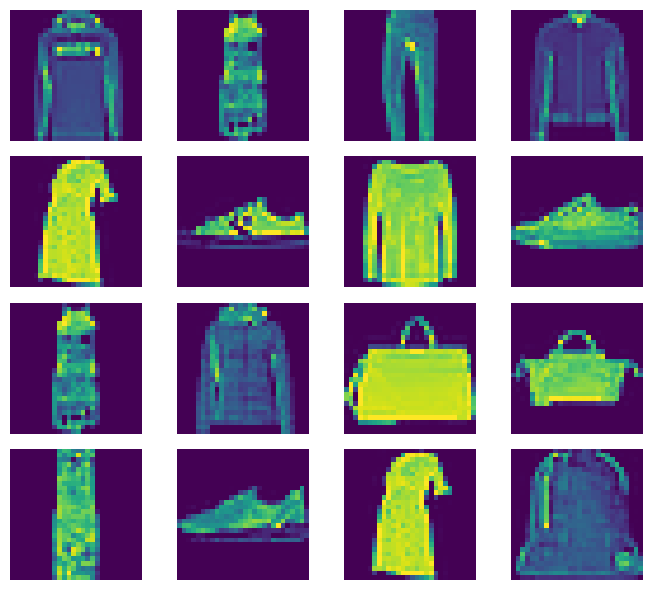

In [8]:
# 5) MNIST Dataset 1개 배치 데이터 확인
images, labels = next(iter(train_dataset_loader))

# labels map 생성
labels_map = { v:k for k, v in train_dataset.dataset.class_to_idx.items() }
print(labels_map)

plt.figure(figsize=(7,6))
cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()
    
    plt.subplot(cols, rows, i)
    plt.imshow(torch.permute(img, (1,2,0)))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
# 6) MLP Model 생성
class MLPDeepLearningModel(nn.Module):
    # model 정의 - 아키텍처를 구성하는 다양한 계층(layer)을 정의
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = self.flatten(x) # 입력층
        x = self.fc1(x) # 은닉층
        x = self.relu(x) # 활성화함수 ReLU(비선형함수)
        x = self.dropout(x) # overfitting 방지
        x = self.fc2(x) # 출력층
        return x

In [10]:
# 7) EarlyStopping 클래스 정의
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience # 개선되지 않아도 기달릴 에폭 수
        self.min_delta = min_delta # 개선으로 간주할 최소 변화량
        self.best_loss = float('inf') # 가장 낮은 validation loss
        self.counter = 0 # 개선되지 않는 에폭 수
        self.early_stop = False # 중단 여부
    
    def __call__(self, val_loss):
        # 매 에폭마다 validation loss를 받아서 개선 여부를 판단한다.
        # val_loss < self.best_loss - self.min_delta 이면 개선된 것으로 간주한다.
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        # 그렇지 않으면 counter를 증가시키고, counter가 patience 이상이면 early_stop을 True로 설정해 학습 중단 신호를 보낸다.
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [11]:
# 8) model, loss, optimizer 객체 생성 및 StepLR 스케줄러 정의
# model 객체 생성
model = MLPDeepLearningModel().to(DEVICE)

# loss function, CrossEntropyLoss 손실함수에는 Softmax 함수 포함되어 있음
loss_function = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

# StepLR 스케줄러 정의
scheduler = StepLR(optimizer, step_size=5, gamma=0.5) # 5 에폭마다 학습률을 절반으로 감소

In [12]:
# 9) 모델 train 함수
def model_train(dataloader, model, loss_function, optimizer):
    model.train() # 확습모드

    train_loss_sum = 0
    train_correct = 0
    train_total = 0
    total_train_batch = len(dataloader)

    for images, labels in dataloader:
        
        # x_train = images.view(-1, 28 * 28).to(DEVICE) # 처음 크기는 (batch_size, 1, 28, 28) -> (batch_size, 784) 1차원 벡터로 변환
        x_train = images.to(DEVICE) # model.forward()에서 flatten 처리되므로 코드에서 제거
        y_train = labels.to(DEVICE)

        # 모델 예측값 게산
        outputs = model(x_train)

        # 손실함수값 계산
        loss = loss_function(outputs, y_train)

        # 오차역전파
        optimizer.zero_grad() # 미분 연산 초기화
        loss.backward() # 미분 연산
        optimizer.step() # 미분 연산 후 가중치 바이어스 파라미터 업데이트

        train_loss_sum += loss.item()
        train_total += y_train.size(0)
        train_correct += (torch.argmax(outputs, 1) == y_train).sum().item()
    train_avg_loss = train_loss_sum / total_train_batch # 평균 오차 계산
    train_avg_accuracy = 100 * train_correct / train_total # 평균 정확도 계산

    return train_avg_loss, train_avg_accuracy

In [13]:
# 10) 모델 evaluate 함수
def model_evaluate(dataloader, model, loss_function):
    model.eval() # 추론모드

    with torch.no_grad(): # 미분 연산 하지 않음
        val_loss_sum = 0
        val_correct = 0
        val_total = 0
        total_val_batch = len(dataloader)

        for images, labels in dataloader:
            # x_val = images.view(-1, 28 * 28).to(DEVICE) # 처음 크기는 (batch_size, 1, 28, 28) -> (batch_size, 784) 1차원 벡터로 변환
            x_val = images.to(DEVICE) # model.forward()에서 flatten 처리되므로 코드에서 제거
            y_val = labels.to(DEVICE)

            # 모델 예측값 게산
            outputs = model(x_val)

            # 손실함수값 계산
            loss = loss_function(outputs, y_val)

            val_loss_sum += loss.item()
            val_total += y_val.size(0)
            val_correct += (torch.argmax(outputs, 1) == y_val).sum().item()
        val_avg_loss = val_loss_sum / total_val_batch # 평균 오차 계산
        val_avg_accuracy = 100 * val_correct / val_total # 평균 정확도 계산

        return val_avg_loss, val_avg_accuracy

In [14]:
# 11) 모델 test 함수
def model_test(dataloader, model):
    model.eval() # 추론모드

    with torch.no_grad(): # 미분 연산 하지 않음
        test_loss_sum = 0
        test_correct = 0
        test_total = 0
        total_test_batch = len(dataloader)

        for images, labels in dataloader:
            # x_test = images.view(-1, 28 * 28).to(DEVICE) # 처음 크기는 (batch_size, 1, 28, 28) -> (batch_size, 784) 1차원 벡터로 변환
            x_test = images.to(DEVICE) # model.forward()에서 flatten 처리되므로 코드에서 제거
            y_test = labels.to(DEVICE)

            # 모델 예측값 게산
            outputs = model(x_test)

            # 손실함수값 계산
            loss = loss_function(outputs, y_test)
            
            test_loss_sum += loss.item()
            test_total += y_test.size(0)
            test_correct += (torch.argmax(outputs, 1) == y_test).sum().item()
        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100 * test_correct / test_total

        print('accuracy = ', test_avg_accuracy, ', loss = ', test_avg_loss)

In [15]:
# 12) 모델 전체 테스트셋 추론 및 오답 시각화

# 전체 테스트셋 추론 함수
def model_all_test(dataloader, model):
    model.eval() # 추론 모드

    all_preds = []
    all_labels = []
    all_images = []

    test_loss_sum = 0
    test_correct = 0
    test_total = 0
    total_test_batch = len(dataloader)

    with torch.no_grad(): # 미분 연산 하지 않음
        for images, labels in dataloader:
            images = images.to(DEVICE) # 입력 데이터
            labels = labels.to(DEVICE) # 정답 데이터

            outputs = model(images) # 모델 예측
            _, preds = torch.max(outputs, dim=1) # 모델 예측값 추출

            all_preds.extend(preds.cpu().numpy()) # 예측값 넘파이로 변환 후 리스트 담는다.
            all_labels.extend(labels.cpu().numpy()) # 정답값 넘파이로 변환 후 리스트 담는다.
            all_images.extend(images.cpu())

            loss = loss_function(outputs, labels)
            test_loss_sum += loss.item()
            test_total += labels.size(0)
            test_correct += (torch.argmax(outputs, dim=1) == labels).sum().item()

        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100 * test_correct / test_total
        
        print('accuracy = ', test_avg_accuracy, 'loss = ', test_avg_loss)
    
    # 오답 샘플 추출
    wrong_indices = [ i for i in range(len(all_preds)) if all_preds[i] != all_labels[i] ]

    # labels map 생성 - train_dataset 에서 정답 label map을 생성
    labels_map = { v : k for k, v in train_dataset.dataset.class_to_idx.items() }

    # Confusion Matrix 시각화 -----------------------------------------------------------------
    # Confusion Matrix 계산
    cm = confusion_matrix(all_labels, all_preds)
    
    # 시각화
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=list(labels_map.values()), 
                yticklabels=list(labels_map.values()))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

     # Classification Report ----------------------------------------------------------------
     # precision(예측한 것 중에 실제로 맞춘 비율), recall(실제 정답 중에 얼마나 맞췄는지), f1-score(precision과 recall의 조화 평균), support(각 클래스의 샘플 수)
    report = classification_report(all_labels, all_preds, target_names=list(labels_map.values()))
    print('classification report:\n', report)

    # 오답 시각화 ------------------------------------------------------------------------------
    print('\n오답 시각화:')
    plt.figure(figsize=(10, 9))
    cols, rows = 5, 4

    for i in range(1, cols * rows + 1):
        if i > len(wrong_indices):
            break
        idx = wrong_indices[i - 1]
        img = all_images[i].squeeze()
        true_label = all_labels[idx]
        pred_label = all_preds[idx]

        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap='gray')
        plt.title(f'T: {labels_map[true_label]}\nP: {labels_map[pred_label]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [18]:
# 13) 모델 학습 
train_loss_list = []
train_accuracy_list = []

val_loss_list = []
val_accuracy_list = []

start_time = datetime.now()

EPOCHS = 20

early_stopping = EarlyStopping(patience=5, min_delta=0.001)

for epoch in range(EPOCHS):
    # train
    train_avg_loss, train_avg_accuracy = model_train(dataloader=train_dataset_loader,
                                                     model=model,
                                                     loss_function=loss_function,
                                                     optimizer=optimizer)
    train_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_avg_accuracy)

    # evaluate
    val_avg_loss, val_avg_accuracy = model_evaluate(dataloader=validation_dataset_loader,
                                                     model=model,
                                                     loss_function=loss_function)
    val_loss_list.append(val_avg_loss)
    val_accuracy_list.append(val_avg_accuracy)

    # 학습률 스케줄러 업데이트
    scheduler.step()

    # print
    print(
        'epoch : ', '%02d' % (epoch + 1),
        'train loss = ', '{:4f}'.format(train_avg_loss), ', train acc = ', '{:4f}'.format(train_avg_accuracy),
        'val loss = ', '{:4f}'.format(val_avg_loss), ', val acc = ', '{:4f}'.format(val_avg_accuracy),
        'Current LR = ', scheduler.get_last_lr()[0] # 학습률 확인
    )

    # EarlyStopping 체크, 매 에폭마다 val_loss를 기준으로 중단 여부를 확인한다.
    early_stopping(val_avg_loss)
    if early_stopping.early_stop:
        print(f'Early stopping triggered at epoch {epoch + 1}')
        break

# time
end_time = datetime.now()
print('elapsed time => ', end_time -start_time)

epoch :  01 train loss =  0.992665 , train acc =  67.929412 val loss =  0.650674 , val acc =  78.955556 Current LR =  0.01
epoch :  02 train loss =  0.620402 , train acc =  78.905882 val loss =  0.545131 , val acc =  81.900000 Current LR =  0.01
epoch :  03 train loss =  0.542995 , train acc =  81.592157 val loss =  0.500876 , val acc =  83.000000 Current LR =  0.01
epoch :  04 train loss =  0.503802 , train acc =  82.574510 val loss =  0.473666 , val acc =  83.877778 Current LR =  0.01
epoch :  05 train loss =  0.476830 , train acc =  83.474510 val loss =  0.463893 , val acc =  83.733333 Current LR =  0.005
epoch :  06 train loss =  0.455382 , train acc =  84.282353 val loss =  0.445778 , val acc =  84.700000 Current LR =  0.005
epoch :  07 train loss =  0.446195 , train acc =  84.507843 val loss =  0.442466 , val acc =  84.688889 Current LR =  0.005
epoch :  08 train loss =  0.437205 , train acc =  84.764706 val loss =  0.430586 , val acc =  85.111111 Current LR =  0.005
epoch :  09 

In [19]:
# 14) Test Dataset 정확도, 오차 테스트
model_test(dataloader=test_dataset_loader, model=model)

accuracy =  85.05 , loss =  0.4183367873057009


accuracy =  85.05 loss =  0.4183367873057009


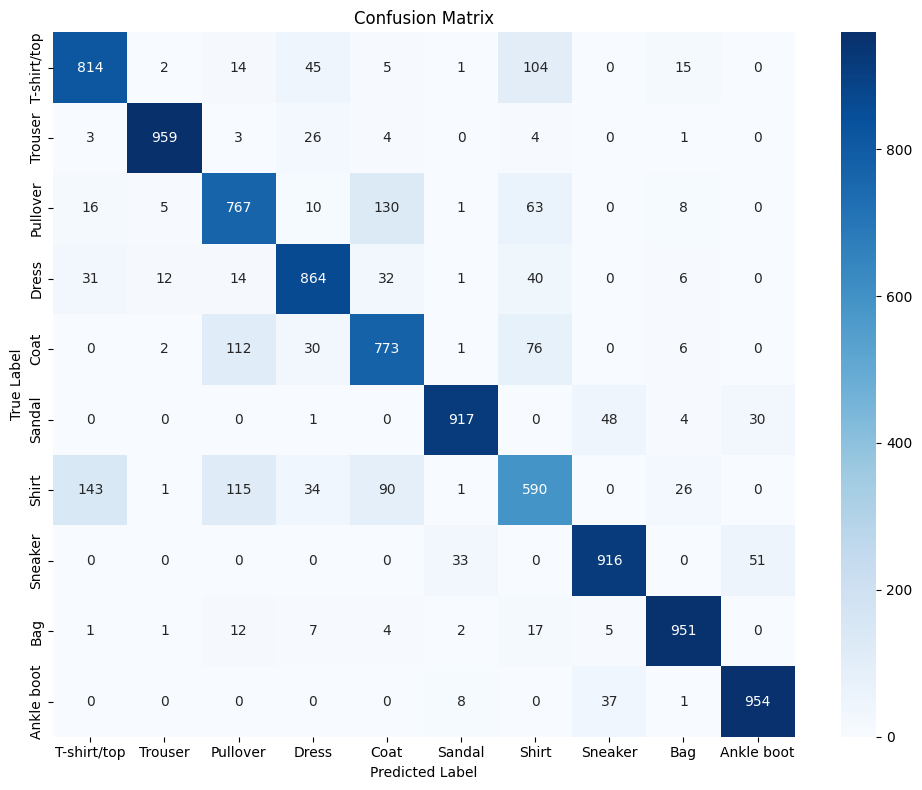

classification report:
               precision    recall  f1-score   support

 T-shirt/top       0.81      0.81      0.81      1000
     Trouser       0.98      0.96      0.97      1000
    Pullover       0.74      0.77      0.75      1000
       Dress       0.85      0.86      0.86      1000
        Coat       0.74      0.77      0.76      1000
      Sandal       0.95      0.92      0.93      1000
       Shirt       0.66      0.59      0.62      1000
     Sneaker       0.91      0.92      0.91      1000
         Bag       0.93      0.95      0.94      1000
  Ankle boot       0.92      0.95      0.94      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000


오답 시각화:


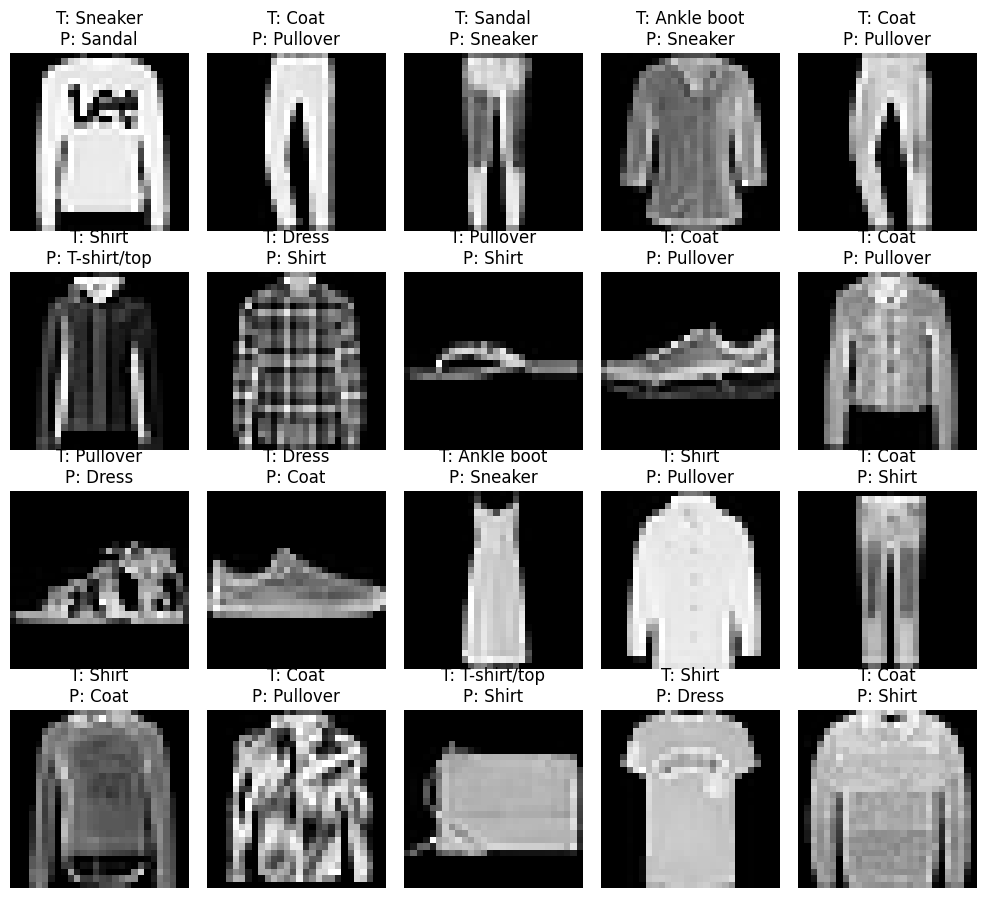

In [20]:
# 15) 모델 전체 테스트셋 추론 및 오답 시각화
model_all_test(dataloader=test_dataset_loader, model=model)

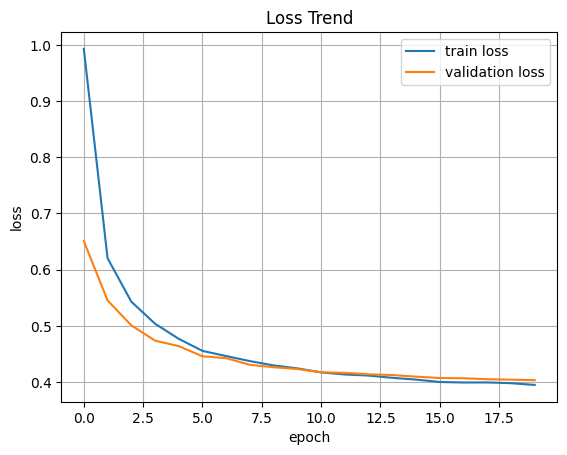

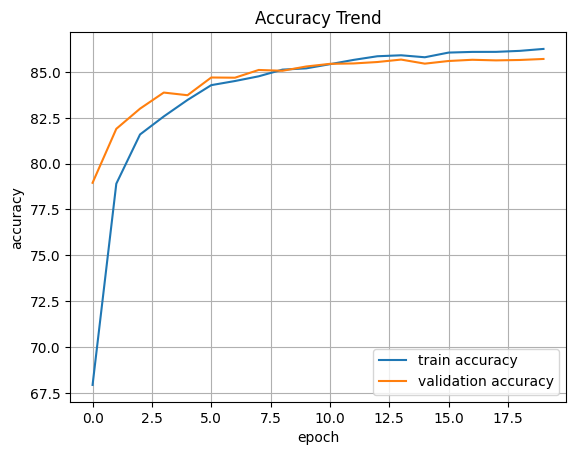

In [21]:
# 16) 시각화 - 손실함수
plt.title('Loss Trend')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='validation loss')
plt.grid()
plt.legend(loc='best')
plt.show()

# 시각화 - 정확도
plt.title('Accuracy Trend')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(train_accuracy_list, label='train accuracy')
plt.plot(val_accuracy_list, label='validation accuracy')
plt.grid()
plt.legend(loc='best')
plt.show()

In [22]:
# 17) Save the model checkpoint
os.makedirs('./models', exist_ok=True)
torch.save(model.state_dict(), './models/model_mlp_fashion_mnist.ckpt')

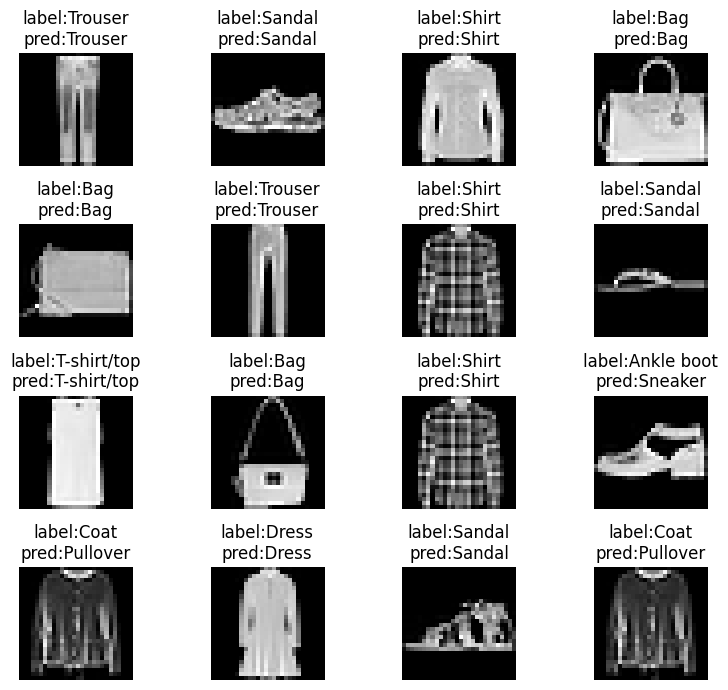

In [23]:
# 18) 단순 32개 샘플 테스트 - 모델 추론 및 예측값 추출
model = MLPDeepLearningModel().to(DEVICE)
model.load_state_dict(torch.load('./models/model_mlp_fashion_mnist.ckpt'))

BATCH_SIZE = 32

# test dataloader
test_image_loader = DataLoader(dataset=test_dataset,
                               batch_size=BATCH_SIZE,
                               shuffle=False)
# test dataset 1개 배치 추출
test_images, test_labels = next(iter(test_image_loader))

# 학습/정답 데이터
x_test = test_images.to(DEVICE)
y_test = test_labels.to(DEVICE)

# 모델 추론
outputs = model(x_test)

# 모델 예측값 추출
_, preds = torch.max(outputs, 1)


# 단순 32개 샘플 시각화 - 추론 및 정답 비교

# labels map 생성 - train_dataset 에서 정답 label map을 생성
labels_map = { v : k for k, v in train_dataset.dataset.class_to_idx.items() }

# 시각화
plt.figure(figsize=(8, 7))

cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    plt.subplot(rows, cols, i)

    # torch.randint()를 통한 1개의 index 추출
    sample_idx = torch.randint(len(x_test), size=(1,)).item()
    
    # test dataloder에서 image, label, pred 값을 추출하여 시각화 비교
    img, label, pred = test_images[sample_idx], test_labels[sample_idx].item(), preds[sample_idx].item()

    plt.title('label:' + labels_map[label] + '\npred:' + labels_map[pred])
    # plt.imshow(torch.permute(img, (1, 2, 0))) # 본래 이미지 shape (3, 224, 224) -> 시각화 하기 위해서 (224, 224, 3) 변환
    plt.imshow(img.squeeze(), cmap='gray') # FashionMNIST는 흑백 이미지(1채널)이므로 permute는 불필요하며, squeeze()로 채널 제거 후 cmap='gray'를 사용하는 것이 좋다.
    plt.axis('off')
plt.tight_layout()
plt.show()